In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib notebook 

from fluid2 import FLUID    #### Generic fluid solver
from pib2 import PIB2        #### 2D Immersed Boundary object
from ib2 import IB2
import warnings; warnings.simplefilter('ignore')


We model a droplet with an immersed boundary method. We use a penalty immersed boundary method to account for excess mass of the fluid within the droplet, and we use an immersed boundary method for an elastic boundary to model the surrounding membrane.

# Modeling an Elastic Membrane

The elastic membrane is easy to model. We follow the formalism of the standard IBM, where the boundary forces derive from the stretching energy of the boundary;


The size of this membrane is determined by surface tension, characterized by the elastic modulus K. 

In [2]:
#### Iterate fluids and immersed solids using built-in functions
def iterate(fluid, solids, ext=None):
    dt = fluid.dt
    fluid.t += dt
    
    ff = 0. ## Force density on fluid
    for solid in solids:
        solid.step_XX(fluid.u)
        ff += solid.ff # Force at midpoint
    if ext is not None:   ## External force on fluid.    **NOTE: add this after the solid forces (not before), otherwise numpy gets cranky
        ff += ext
    uu=fluid.step_u(ff) # Step Fluid Velocity
    for solid in solids:
        solid.step_X(uu) # full step using midpoint velocity            

        
#### Set the boundary points of solid to a circle of specified radius (float) and position (1x2 float)
def CIRCLE(Nb, RAD, POS):  
    theta = np.linspace(0, 2*np.pi, Nb)
    return np.array(POS)[None, :] + RAD*np.vstack([np.cos(theta), np.sin(theta)]).transpose()

# Elastic Membrane Surface Tension

If we initialize an elastic membrane, surface tension should cause it to (somewhat) shrink:

In [3]:
fluid = FLUID(L=1.2)
fluid.dt = .001

outside = CIRCLE(100, 0.3, (0.5, 0.5))*fluid.L
outside = IB2(outside, fluid.N, fluid.h, fluid.dt)
outside.K = 40.
solids = [outside]
RADIUS = []

<IPython.core.display.Javascript object>


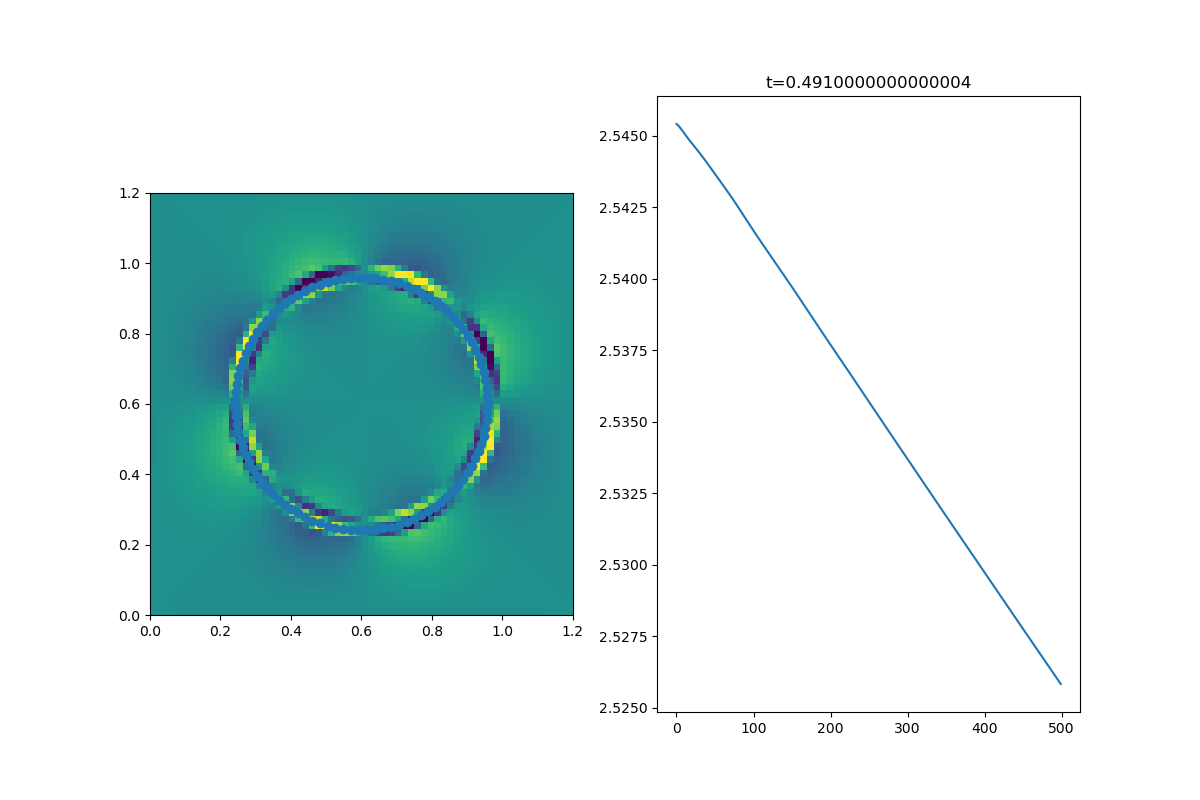

In [4]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax.set_xlim([0, fluid.L])
ax.set_ylim([0, fluid.L])

cmap = plt.get_cmap('tab10')
ims = []

for i in range(500):
    iterate(fluid, solids)
    x0 = outside.X - np.mean(outside.X, axis=0)
    RADIUS.append(np.mean(np.linalg.norm(x0, axis=0)))
#     RADIUS.append(np.mean(np.linalg.norm(outside.X - np.mean(outside.X, axis=0), axis=1)))

    if i%10==0:
        im = [fluid.show_vorticity(ax)]
        for j, solid in enumerate(solids):
            im.append(ax.scatter(solid.X[:,0]%fluid.L, solid.X[:,1]%fluid.L, color=cmap(2*j)))
            
        im.append(plt.title('t={}'.format(1*fluid.t)))
        ims.append(im)
        plt.show()
        
ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=100)
ax2.plot(RADIUS)
# ani.save('circle_shrinking_nodroplet.gif', writer='pillow')

plt.show()

# Sedimentation

To add mass, we add mass markers $Y$ throughout the droplet, connected to immersed boundary points $X$ via stiff springs. In theory, if these springs are infinitely stiff, then the 'penalty' force would cause the mass markers $Y$ to coincide with the boundary points $X$ - however, in practice, the large penalty forces cause numerical instability if the springs are too stiff.

We keep track of the maximum distance between the mass markers $Y$ and boundary points $X$, and try to select a stiffness that keeps this distance below a certain tolerance. The stability will depend on the magnitude of forces and velocities throught the simulation, and we decrease timestep to maintain stable dynamics, when possible/practical. 



To start, we look at two particles subject to gravity with drag. 


In [5]:
def FULL_CIRCLE(h, RAD, POS):
    pts = []
    for x in np.arange(-RAD, RAD, h):
        for y in np.arange(-(RAD**2 - x**2)**0.5, (RAD**2-x**2)**0.5, h):
            pts.append([x, y])
    return (np.vstack([np.array(pts)[:,0], np.array(pts)[:,1]]) + np.array(POS)[:, None]).transpose()

def TRAPPING_PLANE(Y, L):
    out = 0*Y
    out[:,0] = 0
    out[:,1] = np.sin(2*np.pi*Y[:,1]/L)
    return out

def GRAV_withDrag(Y, M, V, cd=1.):
    Fout = np.zeros(np.shape(Y))
    Fout[:,1] -= 980*M 
    maxDrag = abs(cd*V) - abs(Fout)  > 1e-6
    Fout -= cd*V
    Fout[maxDrag] = 0
    return Fout


<IPython.core.display.Javascript object>


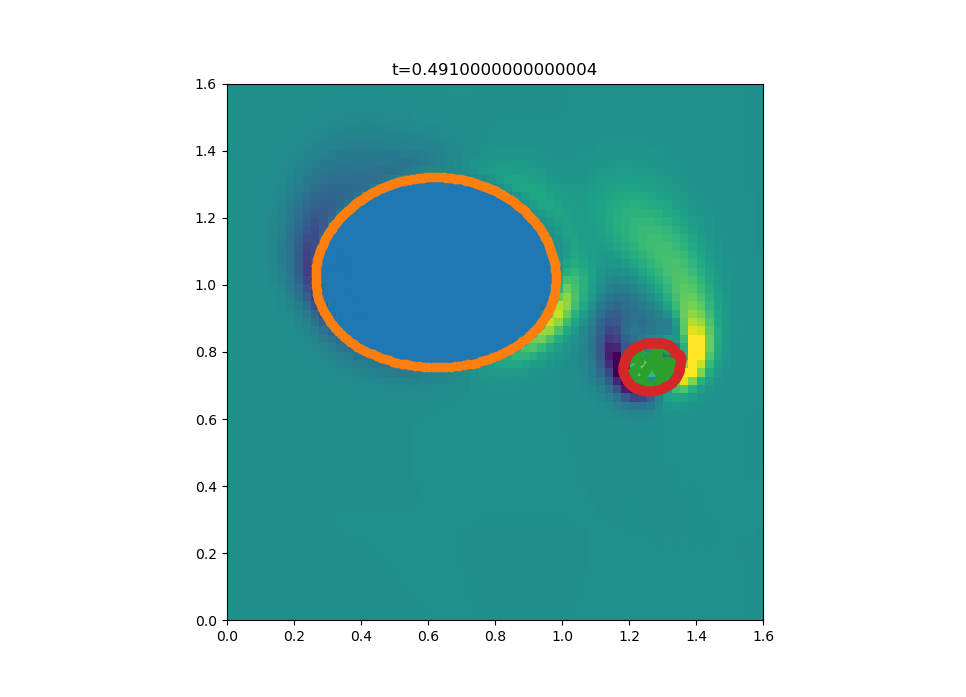

In [17]:
fluid = FLUID(L=1.6)
fluid.dt = .001

## Droplet 1
inside1 = FULL_CIRCLE(fluid.h/2., 0.2, (0.4, 0.85))*fluid.L
outside1 = CIRCLE(200, 0.2, (0.4, 0.85))*fluid.L

## Droplet 2
inside2 = FULL_CIRCLE(fluid.h/2., 0.05, (0.7, 0.9))*fluid.L
outside2 = CIRCLE(200, 0.05, (0.7, 0.9))*fluid.L

#### Specify stiffness and body forces. Choose K=2500 to correspond to dt=.001, via ~ trial and error
drop_in1= PIB2(inside1, fluid.N, fluid.h, fluid.dt)
drop_in1.Kp = 2500        
drop_in1.bForce = lambda Y: GRAV_withDrag(Y, drop_in1.M, drop_in1.V) 
drop_out1 = IB2(outside1, fluid.N, fluid.h, fluid.dt)
drop_out1.K = 40.


#### Specify stiffness and body forces. Choose K=2500 to correspond to dt=.001, via ~ trial and error
drop_in2= PIB2(inside2, fluid.N, fluid.h, fluid.dt)
drop_in2.Kp = 2500        
drop_in2.bForce = lambda Y: GRAV_withDrag(Y, drop_in2.M, drop_in2.V) 
drop_out2 = IB2(outside2, fluid.N, fluid.h, fluid.dt)
drop_out2.K = 80.

insides = [drop_in1, drop_in2]
solids = [drop_in1, drop_out1, drop_in2, drop_out2]


## Keep track of |X-Y|/h
delta = [[] for inside in insides]
V = [[] for inside in insides]



#### Animation
fig, ax = plt.subplots()
fig.figsize=(12, 8)
plt.xlim([0, fluid.L])
plt.ylim([0, fluid.L])

cmap = plt.get_cmap('tab10')
ims = []


In [18]:
for i in range(500):
    iterate(fluid, solids)
    #### Keeping track of 'interior' properties
    for j, iin in enumerate(insides):
        delta[j].append(np.max(np.linalg.norm(iin.Y - iin.X, axis=1)))
        V[j].append(np.mean(iin.V, axis=0))
    if i%10==0:
        print(i)
        im = [fluid.show_vorticity(ax)]
        for j, solid in enumerate(solids):
            im.append(ax.scatter(solid.X[:,0]%fluid.L, solid.X[:,1]%fluid.L, color=cmap(j)))
        im.append(plt.title('t={}'.format(1*fluid.t)))
        ims.append(im)
        
        
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


<IPython.core.display.Javascript object>


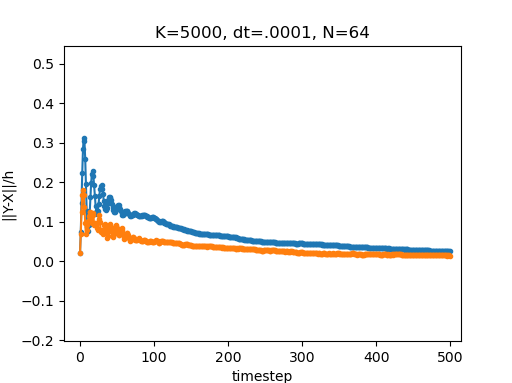

(812,)


<IPython.core.display.Javascript object>


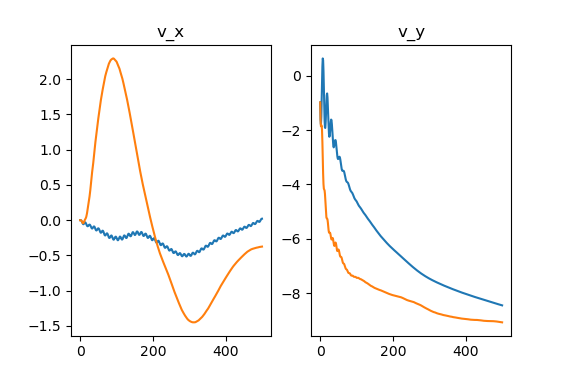

Text(0.5, 1.0, 'v_y')

In [19]:
ani = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)

plt.figure()
plt.ylim([-1., 5.])
print(np.shape(np.linalg.norm(solids[0].Y - solids[0].X, axis=1)))
plt.plot(np.array(delta).transpose()/fluid.h, marker='.')
plt.ylabel('||Y-X||/h')
plt.xlabel('timestep')
plt.title('K=5000, dt=.0001, N=64')

plt.figure()
plt.subplot(1, 2, 1)
vel = np.array(V)
for v in vel:
    plt.plot(v[:, 0])
plt.title('v_x')


plt.subplot(1, 2, 2)
for v in vel:
    plt.plot(v[:, 1])
plt.title('v_y')

In [20]:
ani.save('drop_grav_2_second.gif', writer='pillow')

# Droplet in a Trapping Plane

We simulate a droplet in a sin-wave trapping plane force, $f(y) = A\sin 2\pi y/L_y$

<IPython.core.display.Javascript object>


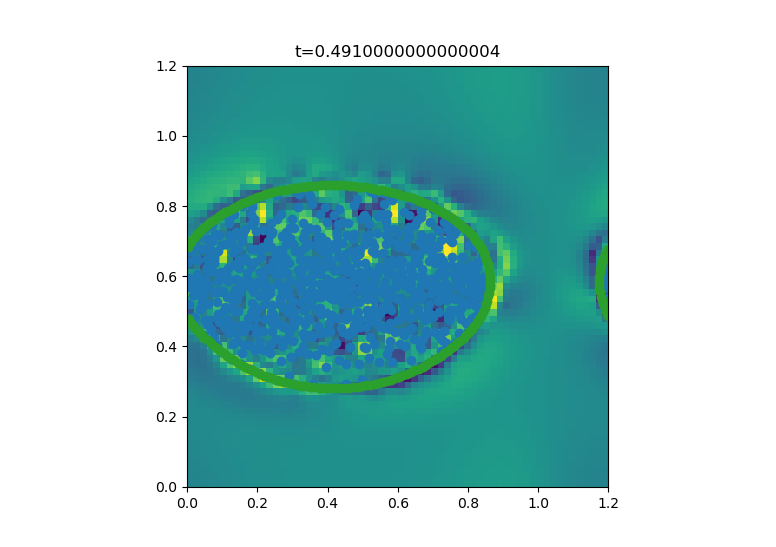

In [25]:
fluid = FLUID(L=1.2)
fluid.dt = .001

inside = FULL_CIRCLE(fluid.h, 0.3, (0.35, 0.85))*fluid.L
outside = CIRCLE(200, 0.3, (0.35, 0.85))*fluid.L

solid1 = PIB2(inside, fluid.N, fluid.h, fluid.dt)
solid1.Kp = 2500
solid1.bForce = lambda Y: GRAV_withDrag(Y, solid1.M, solid1.V) + 100*TRAPPING_PLANE(Y, fluid.L)
solid2 = IB2(outside, fluid.N, fluid.h, fluid.dt)
solid2.K = 80.
solids = [solid1, solid2]

delta = []

#### Animation
fig, ax = plt.subplots()
fig.figsize=(12, 8)
plt.xlim([0, fluid.L])
plt.ylim([0, fluid.L])

cmap = plt.get_cmap('tab10')
ims = []


In [26]:
for i in range(500):
    iterate(fluid, solids)
    delta.append(np.max(np.linalg.norm(solids[0].Y - solids[0].X, axis=0)))
    
    if i%10==0:
        print(i)
        im = [fluid.show_vorticity(ax)]
        for j, solid in enumerate(solids):
            im.append(ax.scatter(solid.X[:,0]%fluid.L, solid.X[:,1]%fluid.L, color=cmap(2*j)))
        im.append(plt.title('t={}'.format(1*fluid.t)))
        ims.append(im)
        plt.show()
        
        

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


<IPython.core.display.Javascript object>


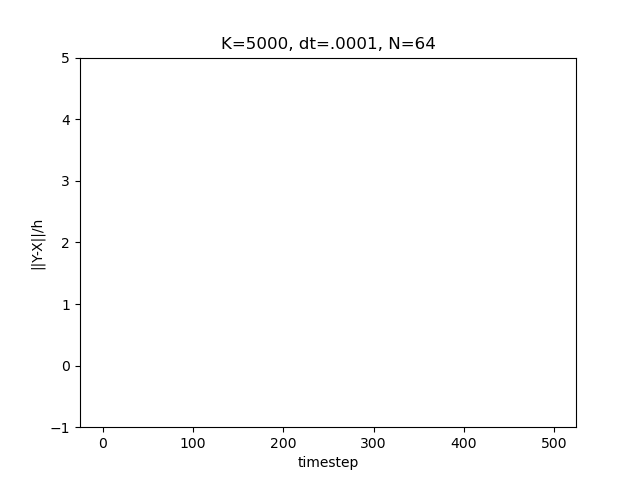

Text(0.5, 1.0, 'K=5000, dt=.0001, N=64')

In [27]:
ani = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)

plt.figure()
plt.ylim([-1., 5.])
plt.plot(np.array(delta)/fluid.h, marker='.')
plt.ylabel('||Y-X||/h')
plt.xlabel('timestep')
plt.title('K=5000, dt=.0001, N=64')

In [28]:
ani.save('pulled_droplet.gif', writer='pillow')

## (deprecated)

<IPython.core.display.Javascript object>


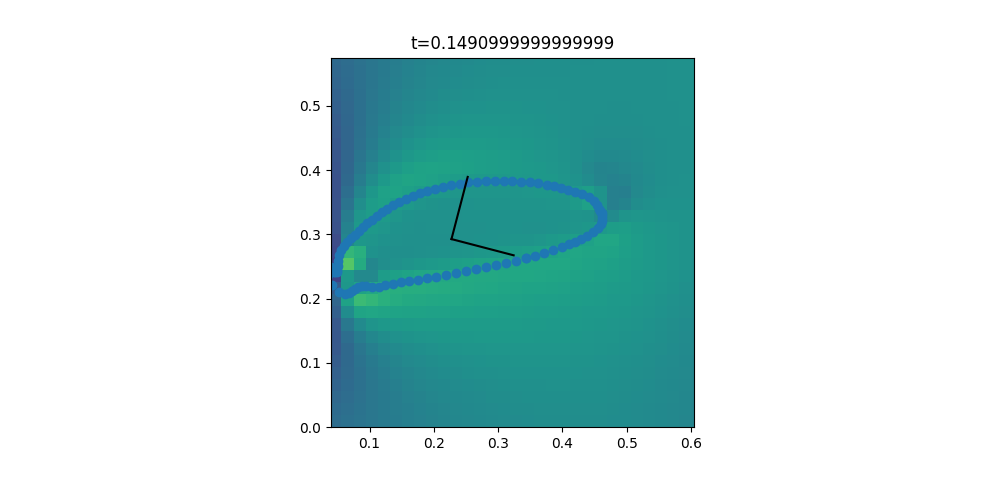

(2, 1500, 2)


In [7]:
def channel(u):
    u[0][0,:] = 0.
    u[0][-1,:] = 0.

    u[1][0,:] = 0.
    u[1][-1,:] = 0.

fluid = FLUID(L=1.2)
fluid.dt = .0001
fluid.boundary = channel
# fluid.eta = 10.

# fig, ax = plt.subplots()
# fig.figsize=(8, 8)
# fluid.show_streamlines(ax, cmap='coolwarm')
# plt.title('Initial Velocity Profile')
# plt.show()

circle1 = CIRCLE(100, 0.1, (0.25, 0.8))*fluid.L
circle2 = CIRCLE(100, 0.1, (0.75, 0.8))*fluid.L

circle1[0] *= 1+0.5*np.sin(np.linspace(0, 2*np.pi, len(circle1[0])))

solid1 = PIB2(circle1, fluid.N, fluid.h, fluid.dt)
solid1.Kp = 5000
solid2 = PIB2(circle2, fluid.N, fluid.h, fluid.dt)
solid2.Kp = 5000
solids = [solid1, solid2]

YCM = [[] for solid in solids]
VCM = [[] for solid in solids]
E = [[] for solid in solids]
L = [[] for solid in solids]
delta = [[] for solid in solids]

#### Animation
fig, ax = plt.subplots()
fig.figsize=(12, 8)
plt.xlim([0, fluid.L])
plt.ylim([0, fluid.L])

cmap = plt.get_cmap('tab10')
ims = []

for i in range(1500):
    iterate(fluid, solids)
    for j, solid in enumerate(solids):
        delta[j].append(np.max(np.linalg.norm(solid.Y - solid.X, axis=0)))
        YCM[j].append(solid.YCM.copy())
        VCM[j].append(solid.VCM.copy())
        L[j].append(solid.L)
        E[j].append(solid.E.copy())
    if i%10==0:
        im = [fluid.show_vorticity()]
#         lines, arrows = fluid.show_streamlines(ax)
#         im.append(lines)
#         im.append(arrows)
        for j, solid in enumerate(solids):
            im.append(plt.scatter(solid.X[0], solid.X[1], color=cmap(2*j)))
#             im.append(plt.scatter(solid.Y[0], solid.Y[1], color=cmap(2*j+1)))
#             im.append(plt.scatter([solid.X[0][0]], [solid.X[1][0]], color=cmap(2*j+1)))
            im.extend(draw_E(solid))
#             im.append(plt.scatter(solid.XX[0], solid.XX[1], color=cmap(2*i+1)))
        im.append(plt.title('t={}'.format(1*fluid.t)))
        ims.append(im)
        plt.show()
        
ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=100)
# # ani.save('circle_in_init_shear.mp4')

# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()
# print(np.shape(solids[0].X))
# print(np.shape(solids[0].ff))
# print(np.shape(fluid.u))

print(np.shape(YCM))
E0 = E.copy()
YCM0 = YCM.copy()
VCM0 = VCM.copy()

<IPython.core.display.Javascript object>


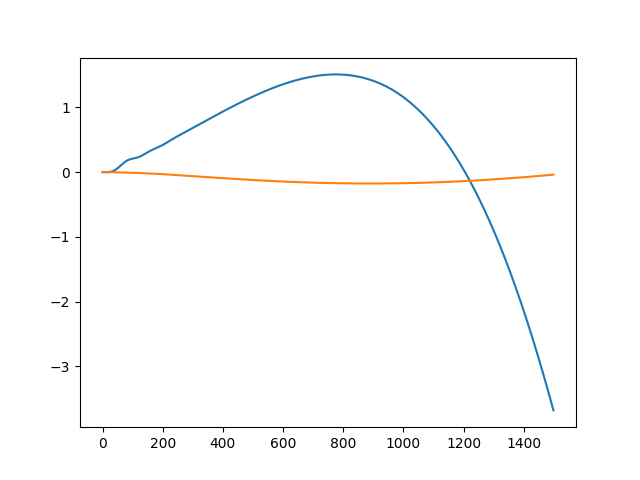

In [8]:
plt.figure()
plt.plot(L[0])
plt.plot(L[1])

(2, 500, 2)
(2, 500, 2, 2)
[[ 0.25680395 -0.73752234]
 [ 0.10401102  1.09833731]]


<IPython.core.display.Javascript object>


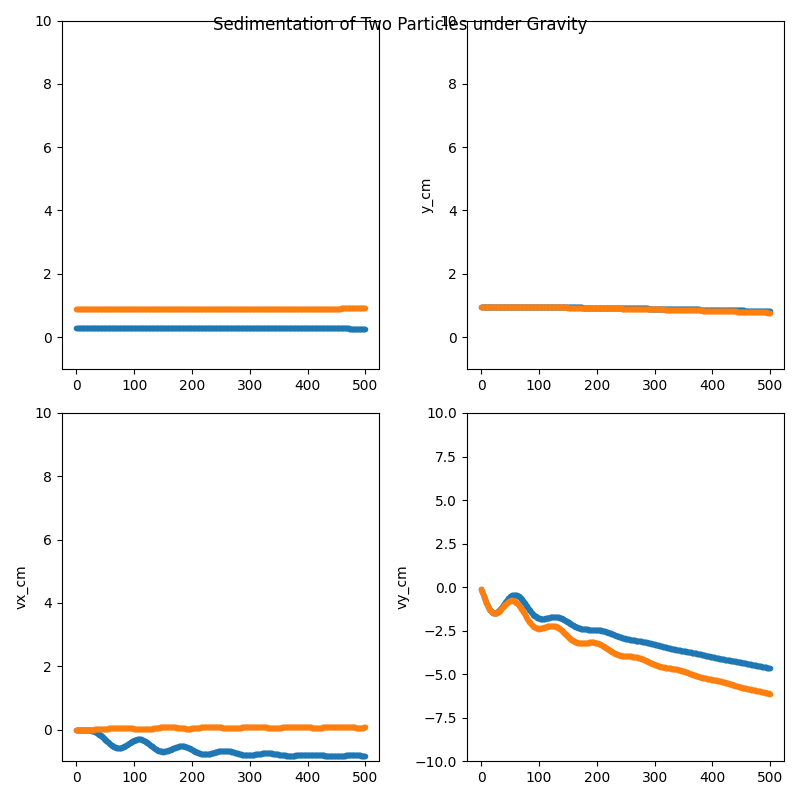

<IPython.core.display.Javascript object>


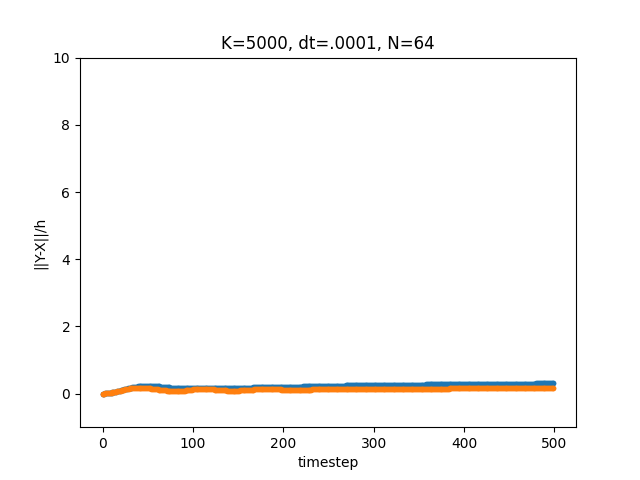

Text(0.5, 1.0, 'K=5000, dt=.0001, N=64')

In [10]:

YCM = [np.array(el) for el in YCM0]
VCM = [np.array(el) for el in VCM0]
print(np.shape(YCM0))
print(np.shape(E0))
plt.figure(figsize=(8, 8))
plt.subplot(2,2,1)

for el in YCM:
    plt.plot(el[:,0], marker='.')
plt.ylim([-1., 10.])

plt.subplot(2,2,2)
for el in YCM:
    plt.plot(el[:,1], marker='.')
plt.ylabel('y_cm')
plt.ylim([-1., 10.])

plt.subplot(2,2,3)
for el in VCM:
    plt.plot(el[:,0], marker='.')
plt.ylabel('vx_cm')
plt.ylim([-1., 10.])

plt.subplot(2,2,4)
for el in VCM:
    plt.plot(el[:,1], marker='.')
plt.ylabel('vy_cm')
plt.ylim([-10., 10.])
plt.suptitle('Sedimentation of Two Particles under Gravity')

plt.tight_layout()

plt.figure()
plt.ylim([-1., 10.])
for el in delta:
    plt.plot(np.array(el)/fluid.h, marker='.')
plt.ylabel('||Y-X||/h')
plt.xlabel('timestep')
plt.title('K=5000, dt=.0001, N=64')